In [1]:
# ---------------- processing Raman data to extract spectra images and peak parameters
    
    # --- import modules

import os
import pandas as pd
import numpy as np
#import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#from lmfit.models import PseudoVoigtModel, ExponentialModel, GaussianModel


    # --- set working directory

#base_dir = "C:/Users/u0125722/Box Sync/Buranga/_Article2-Buranga_mineral_evolution/Raman_spectra/baseline_corrected/"
base_dir = "E:/Raman_sultan/"

In C:\Users\u0125722\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In C:\Users\u0125722\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\u0125722\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In C:\Users\u0125722\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\u0125722\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
    # --- get list of files

spectra_files = sorted(os.listdir(base_dir+"spectra"))


peak_files = sorted(os.listdir(base_dir+"peaks"))

    if len(spectra_files) != len(peak_files):
        print('The number of peak files is not the same as of spectra files. Please check.')
    
    else:
        print(spectra_files)
        print(len(spectra_files))
        print("\n")
        print(peak_files)
        print(len(peak_files))

['argentopyrite-r090026_1800 (450-850nm)_532nm_edge_10%_x100_vis_lwd_h100um_30sx2_01.dat', 'arsenopyrite-r050071_1800 (450-850nm)_532nm_edge_10%_x100_vis_lwd_h100um_30sx2_01.dat', 'chalcopyrite-r050559_1800 (450-850nm)_532nm_edge_10%_x100_vis_lwd_h100um_30sx2_01.dat', 'sul-nc-02-a-1_1800 (450-850nm)_532nm_edge_10%_x100_vis_lwd_h100um_30sx2_0.dat', 'sul-nc-02-a-2_1800 (450-850nm)_532nm_edge_10%_x100_vis_lwd_h100um_30sx2_0.dat', 'sul-nc-02-a-4_150 (500nm)_532nm_edge_10%_x100_vis_lwd_h100um_15sx2_0.dat', 'sul-nc-02-b-1_1800 (450-850nm)_532nm_edge_10%_x100_vis_lwd_h100um_30sx2_0.dat']
7


['argentopyrite-r090026_1800 (450-850nm)_532nm_edge_10%_x100_vis_lwd_h100um_30sx2_01.peaks', 'arsenopyrite-r050071_1800 (450-850nm)_532nm_edge_10%_x100_vis_lwd_h100um_30sx2_01.peaks', 'chalcopyrite-r050559_1800 (450-850nm)_532nm_edge_10%_x100_vis_lwd_h100um_30sx2_01.peaks', 'sul-nc-02-a-1_1800 (450-850nm)_532nm_edge_10%_x100_vis_lwd_h100um_30sx2_0.peaks', 'sul-nc-02-a-2_1800 (450-850nm)_532nm_edge_10%_x10

In [6]:
# --- function to import data from spectrum and peak files and create a combined dataframe

def spectrum_data(spectrum_file):
    
    # --- PART 1: import spectrum data from input file and create a spectrum dataframe

        # --- set file name to be processed
    current_mineral = spectrum_file.replace(".dat", "").replace(".txt", "")

        # --- get input file and save as a spectrum dataframe

# - Use this line if dealing with raw files (exported directly after acquisition)
    
#     df_spectrum = pd.read_csv(base_dir+"spectra/"+current_mineral+".txt", sep='\t', comment='#', 
#                               header=None, names=['wv','intensity'])

# - Use this line if dealing with processed files (exported after fitting the peaks)
    
    df_spectrum = pd.read_csv(base_dir+"spectra/"+current_mineral+".dat", sep=' ', header=None,
                              names=['wv','intensity','stddev','model','residuals','wtresiduals'])
        
        
        # --- add file information
    df_spectrum["file"] = current_mineral
        # --- separate file information into relavant acquisition parameters
    df_spectrum[['sample','grating','laser','edge',
                 'filter','objective','vis','lwd',
                 'pinhole','acquisition','set']]=df_spectrum["file"].str.split(pat='_', expand=True)
    
    df_spectrum = df_spectrum[['file','sample','grating','laser',
                               'filter','objective','pinhole','acquisition',
                               'wv','intensity','stddev','model','residuals','wtresiduals']]
    
    
    
    
    
    

    # --- PART 2: get corresponding peak information from input file 
  
        # --- get lines from the input file
    current_peak_file = open(base_dir+"/peaks/"+current_mineral+".peaks", "r")
    current_peak_lines = current_peak_file.readlines()

    peaks_columns = ['number','function','Center','Height','Area','FWHM','a0','a1','a2','a3']    

        # --- get positions of peak data inside the overall file and append it to a peak list
    counter = 0
    peaks_data_loc = []

    for line in current_peak_lines:
        if "%p" in line:
            peaks_data_loc.append(counter)
        counter += 1

    total_peaks = len(peaks_data_loc)


         # --- grab peak data from each line of the peak list and populate a dictionary with peak parameteres
    peaks_dict = {}

    for line_counter in peaks_data_loc:    
        current_row = current_peak_lines[line_counter].replace("  ","\t").replace(" ","\t").replace("\n","").split("\t")
        current_parameters = [ii for ii in current_row if ii != '']

        peaks_dict[str(line_counter)] = {}

        for attribute,column in zip(current_parameters,peaks_columns):
            peaks_dict[str(line_counter)][column] = attribute


        # --- grab the model fit info and populate a dictionary with each fit parameter
    fit_info = current_peak_lines[-1].replace("  ","\t").replace("\n","").split("\t")

    fit_info_dict = {}

    for line in fit_info:
        split_line = line.split("=")
        fit_info_dict[split_line[0]] = split_line[1]


            # --- final data table
    df_peaks = pd.DataFrame.from_dict(peaks_dict, orient="index")

    df_peaks["mineral"] = current_mineral

    for key,value in fit_info_dict.items():
        df_peaks[key] = value

    #return df_peaks

    
    
    
    # --- PART 3: combine peak parameters with spectrum dataframe

    df_spectrum_peaks = df_spectrum.copy()

        # --- create tuples that will receive each peak parameter

    wv_range = np.array(df_spectrum["wv"])
    current_center_range = np.zeros(df_spectrum.shape[0])
    current_height_range = np.zeros(df_spectrum.shape[0])
    current_area_range = np.zeros(df_spectrum.shape[0])
    current_fwhm_range = np.zeros(df_spectrum.shape[0])
    current_a0_range = np.zeros(df_spectrum.shape[0])
    current_a1_range = np.zeros(df_spectrum.shape[0])
    current_a2_range = np.zeros(df_spectrum.shape[0])
    current_a3_range = np.zeros(df_spectrum.shape[0])
    

        # --- copy peak parameters from peak dataframe

    peak_parameters = df_peaks[['Center','Height','Area','FWHM','a0','a1','a2','a3']].astype(float) 
    # here a float conversion is needed because df_peaks has only strings, and np.where condition will compare wv_range numbers

        # --- loop through peaks in peak dataframe to copy and assign values to tuples created

    for peak, value in peak_parameters['Center'].iteritems():    
        current_center_range[np.where(wv_range>=value)[0][0]] = value
        current_height_range[np.where(wv_range>=value)[0][0]] = peak_parameters['Height'][peak]
        current_area_range[np.where(wv_range>=value)[0][0]] = peak_parameters['Area'][peak]
        current_fwhm_range[np.where(wv_range>=value)[0][0]] = peak_parameters['FWHM'][peak]
        current_a0_range[np.where(wv_range>=value)[0][0]] = peak_parameters['a0'][peak]
        current_a1_range[np.where(wv_range>=value)[0][0]] = peak_parameters['a1'][peak]
        current_a2_range[np.where(wv_range>=value)[0][0]] = peak_parameters['a2'][peak]
        current_a3_range[np.where(wv_range>=value)[0][0]] = peak_parameters['a3'][peak]
              
        
        # --- assign tuples with peak parameters as columns in the spectra dataframe

    df_spectrum_peaks["center"] = current_center_range
    df_spectrum_peaks["height"] = current_height_range
    df_spectrum_peaks["area"] = current_center_range
    df_spectrum_peaks["FWHM"] = current_fwhm_range
    df_spectrum_peaks["G/L"] = current_a3_range
    df_spectrum_peaks["a0"] = current_a0_range
    df_spectrum_peaks["a1"] = current_a1_range
    df_spectrum_peaks["a2"] = current_a2_range
    df_spectrum_peaks["a3"] = current_a3_range
    df_spectrum_peaks["R2"] = df_peaks.iloc[0]['R2']
    df_spectrum_peaks["WSSR"] = df_peaks.iloc[0]['WSSR']
    df_spectrum_peaks["DoF"] = df_peaks.iloc[0]['DoF']
    
        # --- Convert 'a' parameters to numeric for later calculations
    df_spectrum_peaks['a0'] = pd.to_numeric(df_spectrum_peaks['a0'])
    df_spectrum_peaks['a1'] = pd.to_numeric(df_spectrum_peaks['a1'])
    df_spectrum_peaks['a2'] = pd.to_numeric(df_spectrum_peaks['a2'])
    df_spectrum_peaks['a3'] = pd.to_numeric(df_spectrum_peaks['a3'])

    #df_spectrum_peaks.to_csv('C:/Users/u0125722/Documents/Python_Scripts/output/figures/'+current_mineral+".csv",index = None)
    return df_spectrum_peaks



# Define formula of Pseudo-Voigt curve (sum of Gaussian+Lorenzian models)

def gauss_lor_sum(x, a_0, a_1, a_2, a_3):
    return (a_0*(((((a_3*np.sqrt(np.log(2)))/(a_2*np.sqrt(np.pi)))*(np.exp(-4*np.log(2)*(((x-a_1)/a_2)**2))))+((1-a_3)/(np.pi*a_2*(1+(4*(((x-a_1)/a_2)**2))))))/
                 (((a_3*np.sqrt(np.log(2)))/(a_2*np.sqrt(np.pi)))+((1-a_3)/(np.pi*a_2)))))

# Gaussian-Lorentzian Sum (Amplitude) - Peakfit:

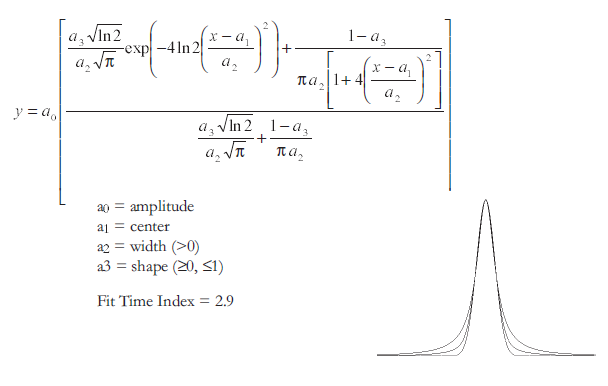

# Voigt (Amplitude, Gaussian/Lorentzian Widths) - Peakfit:

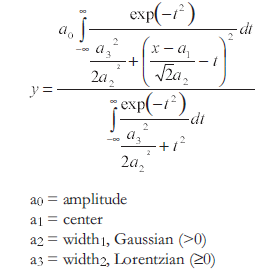

In [8]:
import scipy.integrate as integrate

def gauss_lor_sum(x, a_0, a_1, a_2, a_3):
    f = lambda t: ((np.exp(-t**2))/(((a_3**2)/(2*a_2**2))+((((x-a_1)/(np.sqrt(2)*a_2))-t)**2))
    g = lambda r: ((np.exp(-r**2))/(((a_3**2)/(2*a_2**2))+(r**2)))

    t = np.linspace(-np.inf,np.inf)
    return y = (a_0*f(t))/(g(t))



SyntaxError: invalid syntax (<ipython-input-8-4054e825ca77>, line 5)

In [5]:
df_spectrum_peaks = pd.DataFrame()

for ii in range(len(spectra_files)):
    #print(spectra_files[ii])
    #print(ii)
    a = spectrum_data(spectra_files[ii])
    a = a.drop(['function','Height','Area','a0','a1','a2','a3','WSSR','DoF','WSSR/DoF','SSR','R2'],axis=1).T
    print(a.columns)
    #print(a)
    df_spectrum_peaks = pd.concat([df_spectrum_peaks,a], axis=0, sort=False)
    
# 'number', 'function', 'Center', 'Height', 'Area', 'FWHM', 'a0', 'a1',
       #'a2', 'a3', 'mineral', 'WSSR', 'DoF', 'WSSR/DoF', 'SSR', 'R2'

df_spectrum_peaks.to_csv('C:/Users/u0125722/Documents/Python_Scripts/output/sultan/NC_peak_data.csv',index = True)
df_spectrum_peaks

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], dtype='object')
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13'], dtype='object')
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='object')
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='object')
Index(['1', '2', '3', '4', '5', '6', '7', '8'], dtype='object')
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='object')
Index(['1', '2', '3', '4', '5', '6', '7'], dtype='object')


,1,2,3,4,5,6,7,8,9,10,11,12,13
number,%p1,%p2,%p3,%p4,%p5,%p6,%p7,%p8,%p9,%p10,NaN,NaN,NaN
Center,339.36,372.633,318.797,348.364,389.14,336.937,382.258,366.713,357.476,303.221,NaN,NaN,NaN
FWHM,5.63444,10.1483,14.7552,2.21448,7.07394,11.1987,6.58965,19.4106,2.34993,27.4965,NaN,NaN,NaN
mineral,argentopyrite-r090026_1800 (450-850nm)_532nm_e...,argentopyrite-r090026_1800 (450-850nm)_532nm_e...,argentopyrite-r090026_1800 (450-850nm)_532nm_e...,argentopyrite-r090026_1800 (450-850nm)_532nm_e...,argentopyrite-r090026_1800 (450-850nm)_532nm_e...,argentopyrite-r090026_1800 (450-850nm)_532nm_e...,argentopyrite-r090026_1800 (450-850nm)_532nm_e...,argentopyrite-r090026_1800 (450-850nm)_532nm_e...,argentopyrite-r090026_1800 (450-850nm)_532nm_e...,argentopyrite-r090026_1800 (450-850nm)_532nm_e...,NaN,NaN,NaN
number,%p1,%p2,%p3,%p4,%p5,%p6,%p7,%p8,%p9,%p10,%p11,%p12,%p13
Center,268.448,281.026,404.597,372.637,196.963,425.856,250.565,293.463,329.63,131.996,176.902,307.367,363.104
FWHM,21.2501,8.25988,14.546,5.1239,16.9211,20.4551,8.96657,19.5365,32.833,9.31843,24.9228,4.96902,12.7015
mineral,arsenopyrite-r050071_1800 (450-850nm)_532nm_ed...,arsenopyrite-r050071_1800 (450-850nm)_532nm_ed...,arsenopyrite-r050071_1800 (450-850nm)_532nm_ed...,arsenopyrite-r050071_1800 (450-850nm)_532nm_ed...,arsenopyrite-r050071_1800 (450-850nm)_532nm_ed...,arsenopyrite-r050071_1800 (450-850nm)_532nm_ed...,arsenopyrite-r050071_1800 (450-850nm)_532nm_ed...,arsenopyrite-r050071_1800 (450-850nm)_532nm_ed...,arsenopyrite-r050071_1800 (450-850nm)_532nm_ed...,arsenopyrite-r050071_1800 (450-850nm)_532nm_ed...,arsenopyrite-r050071_1800 (450-850nm)_532nm_ed...,arsenopyrite-r050071_1800 (450-850nm)_532nm_ed...,arsenopyrite-r050071_1800 (450-850nm)_532nm_ed...
number,%p1,%p2,%p3,%p4,%p5,%p6,%p7,%p8,%p9,NaN,NaN,NaN,NaN
Center,318.752,376.178,450.305,345.583,272.496,290.605,168.758,284.372,351.178,NaN,NaN,NaN,NaN


bu19ts(1)-ore1-core_150 (500nm)_532nm_edge_10%_x100_vis_swd_h30um_30sx2_01.dat


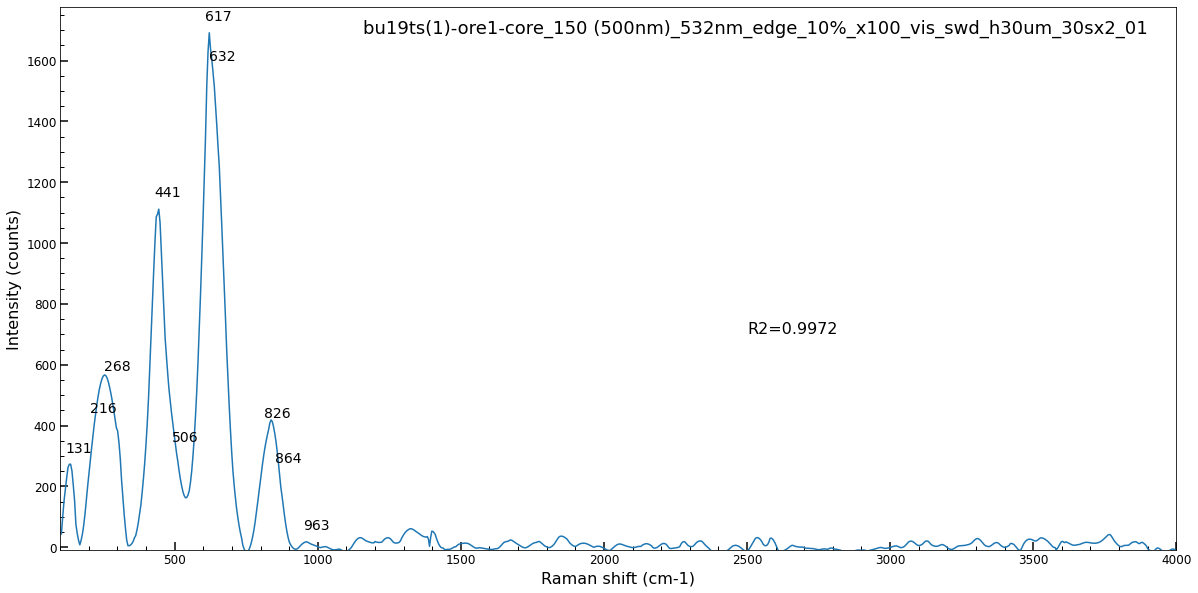

bu19ts(1)-ore1-midbright_150 (500nm)_532nm_edge_10%_x100_vis_swd_h30um_30sx2_01.dat


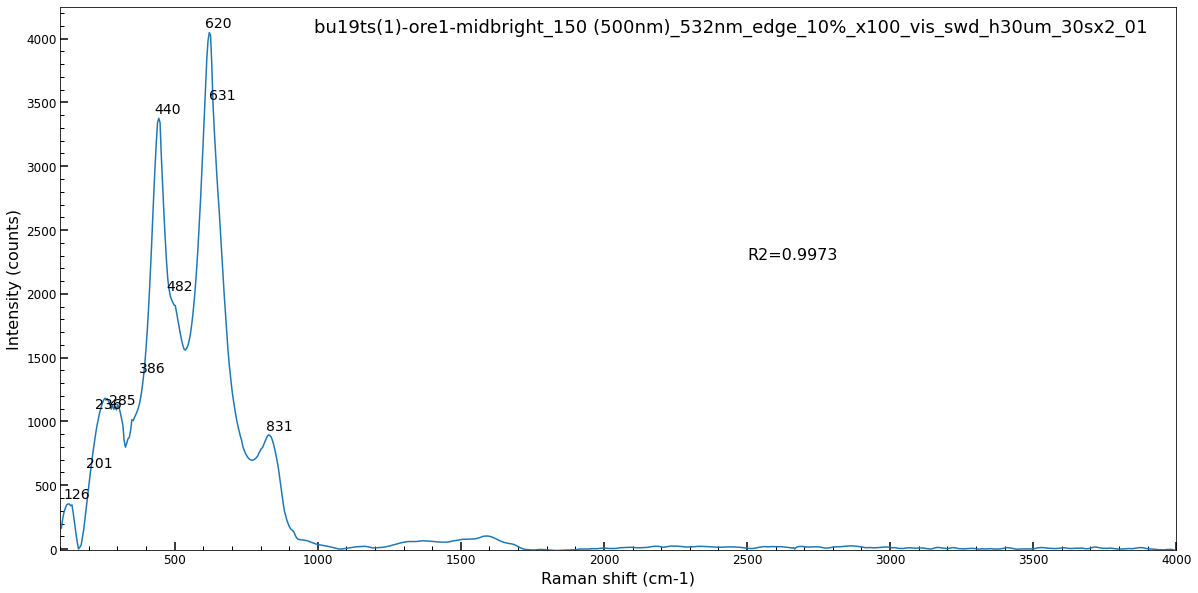

bu19ts(1)-ore1-uptip_150 (500nm)_532nm_edge_10%_x100_vis_swd_h30um_30sx2_01.dat


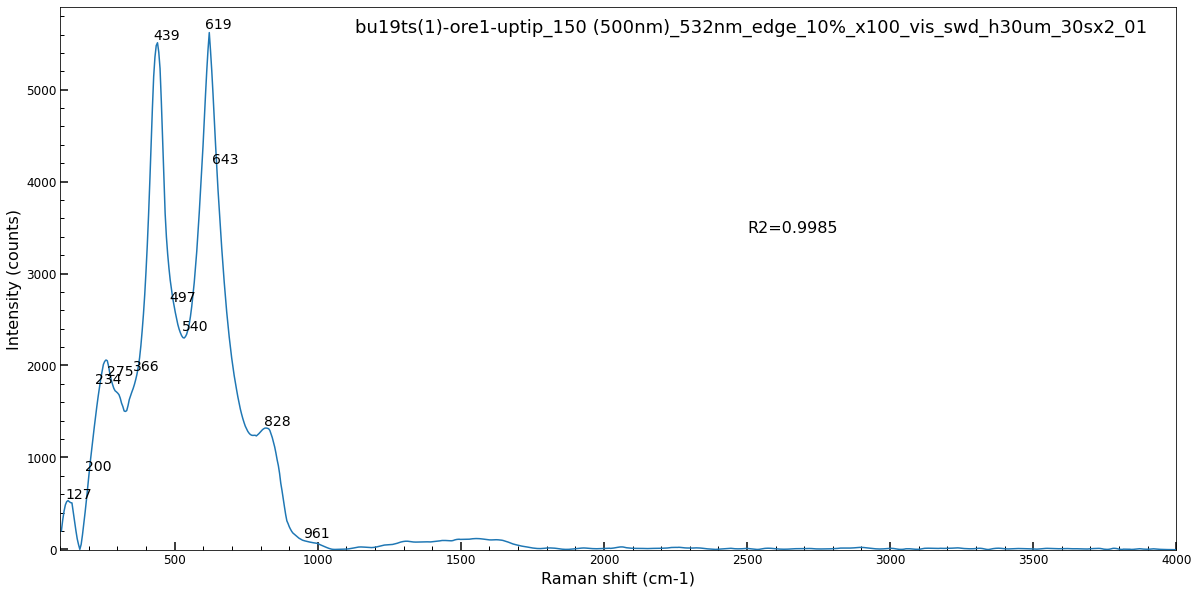

bu19ts(1)-ore2-rim_150 (500nm)_532nm_edge_10%_x100_vis_swd_h30um_30sx2_01.dat


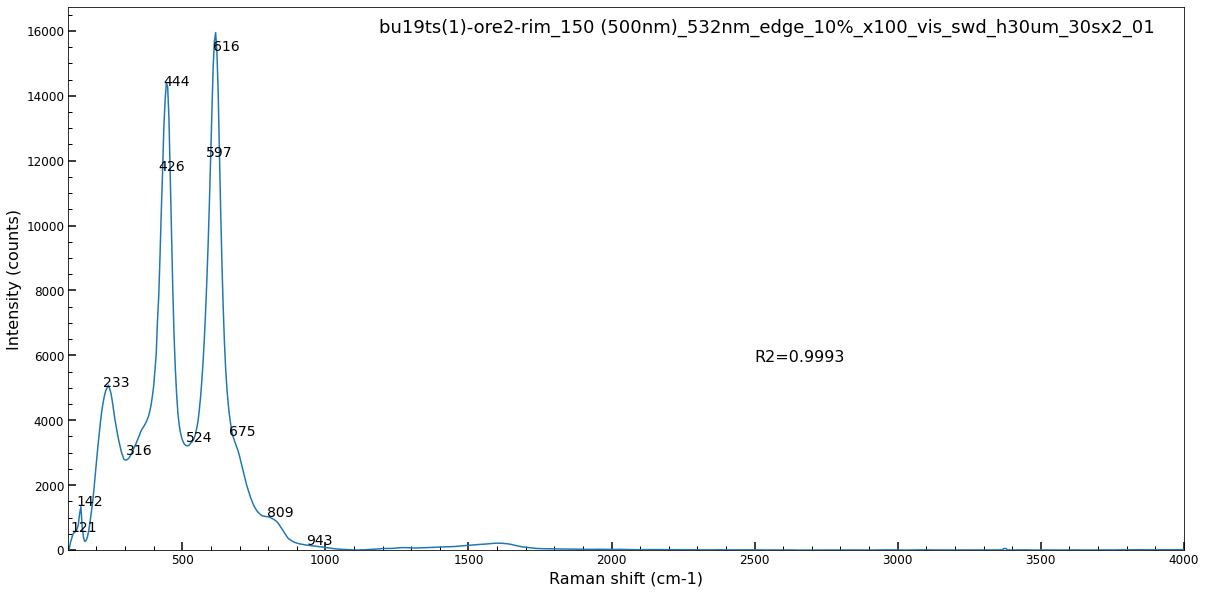

bu19w-ore1-core_150 (500nm)_532nm_edge_10%_x100_vis_swd_h30um_30sx2_01.dat


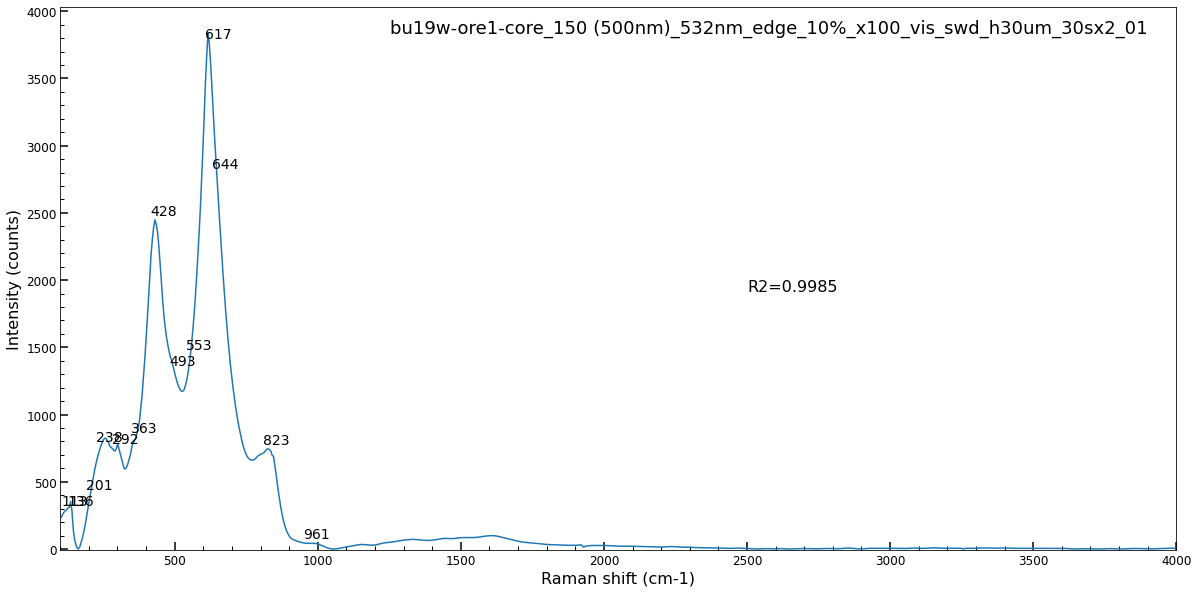

bu19w-ore2-a_150 (500nm)_532nm_edge_10%_x50_vis_lwd_h30um_30sx2_01.dat


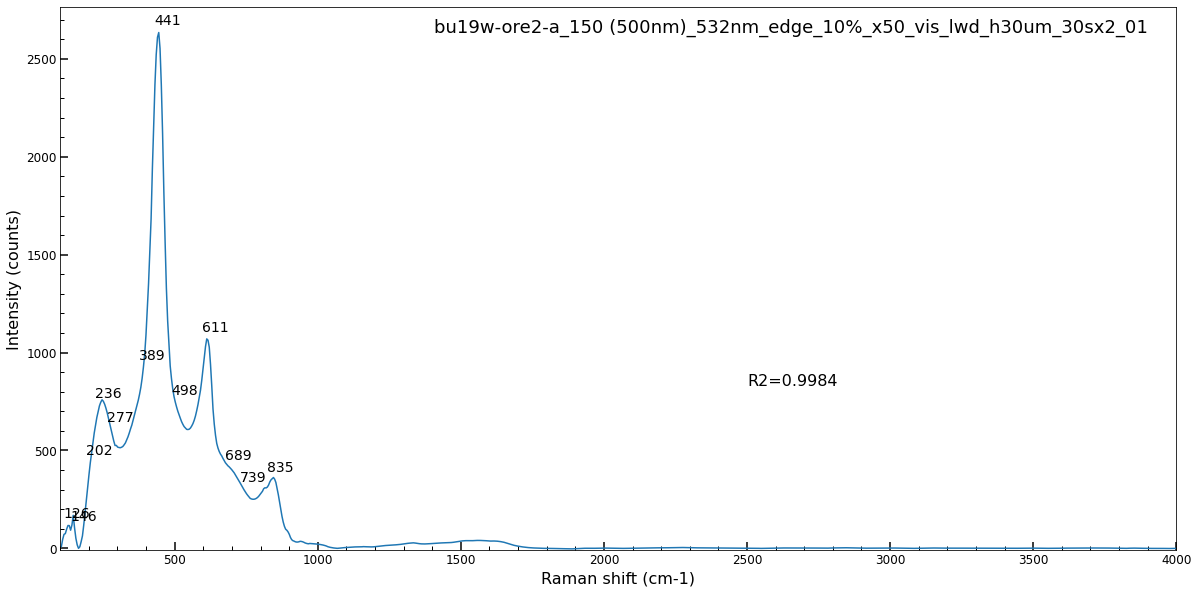

bu19w-ore2-b-core_150 (500nm)_532nm_edge_10%_x50_vis_lwd_h30um_30sx2_01.dat


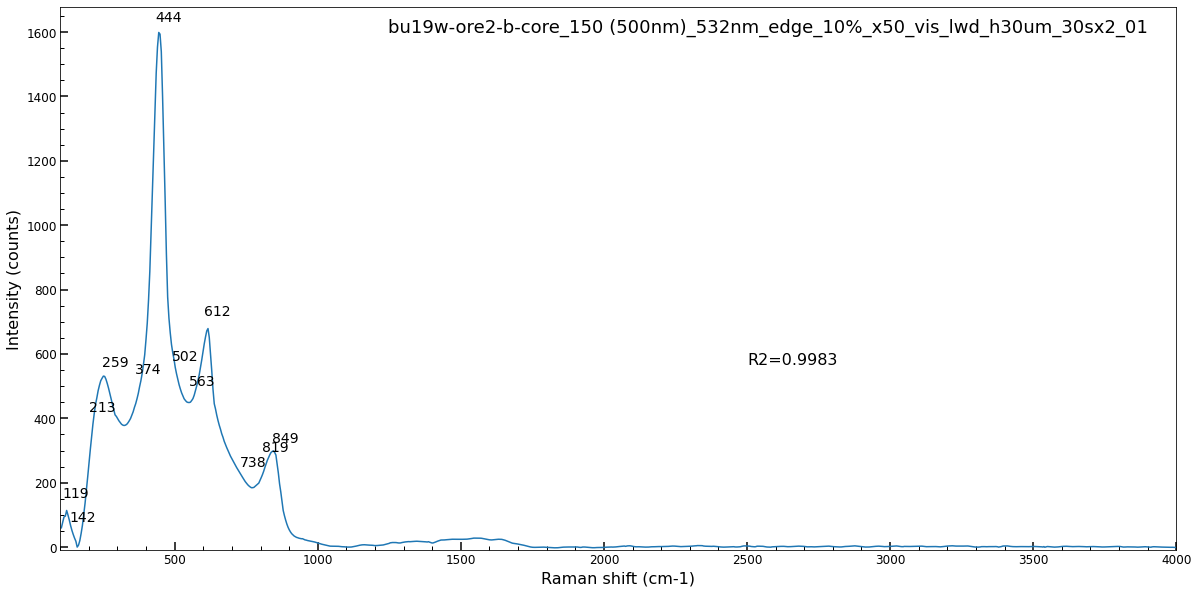

bu19w-ore2-b-overgrowth_150 (500nm)_532nm_edge_10%_x50_vis_lwd_h30um_30sx2_01.dat


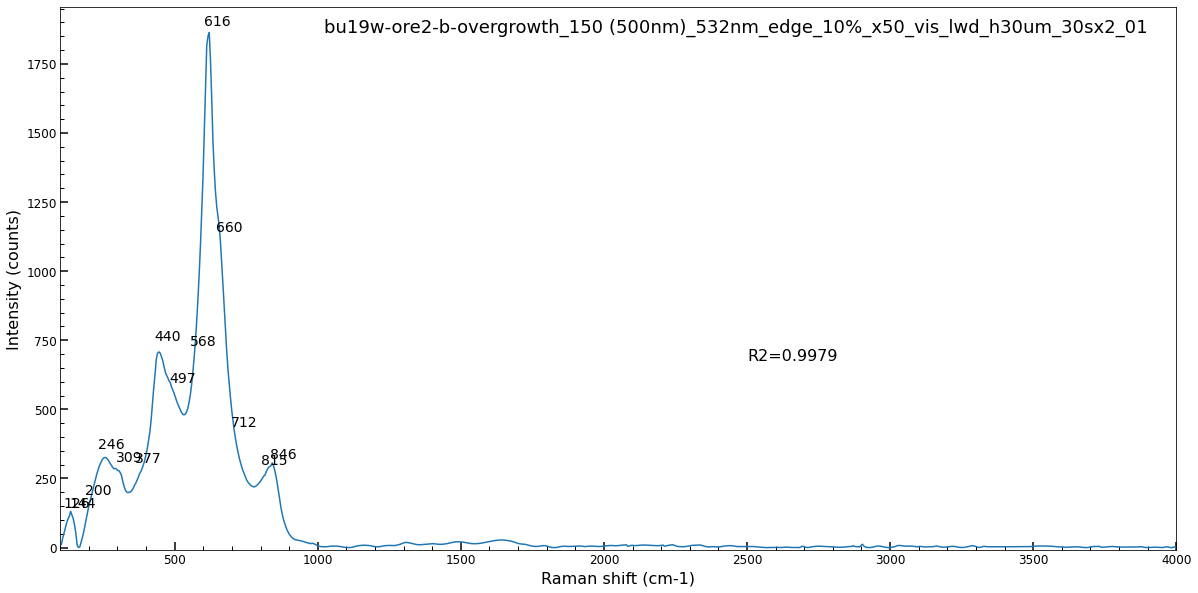

bu19w-ore2-b-rim_150 (500nm)_532nm_edge_10%_x50_vis_lwd_h30um_30sx2_01.dat


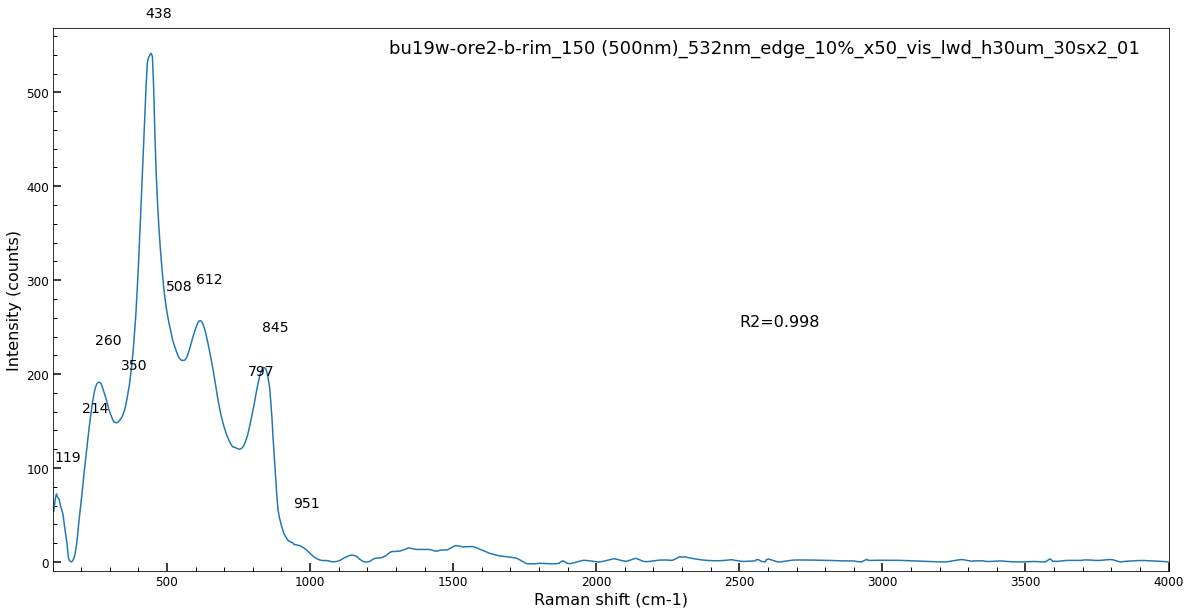

bu19w-ore3-core_150 (500nm)_532nm_edge_10%_x100_vis_swd_h30um_30sx2_01.dat


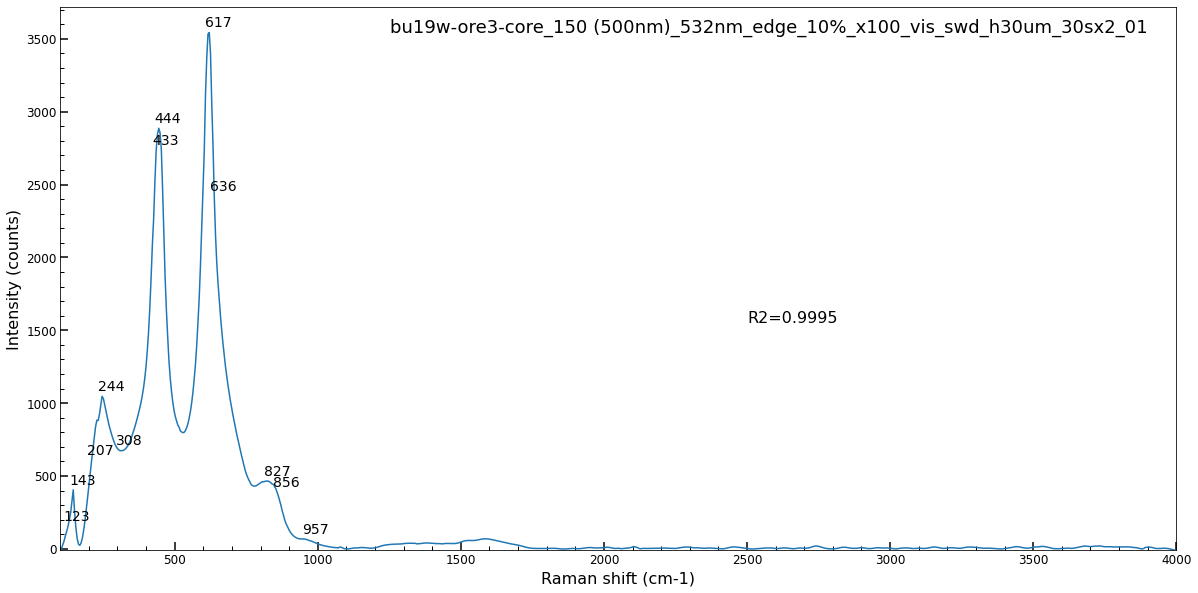

bu19w-ore3-rim_150 (500nm)_532nm_edge_10%_x100_vis_swd_h30um_30sx2_01.dat


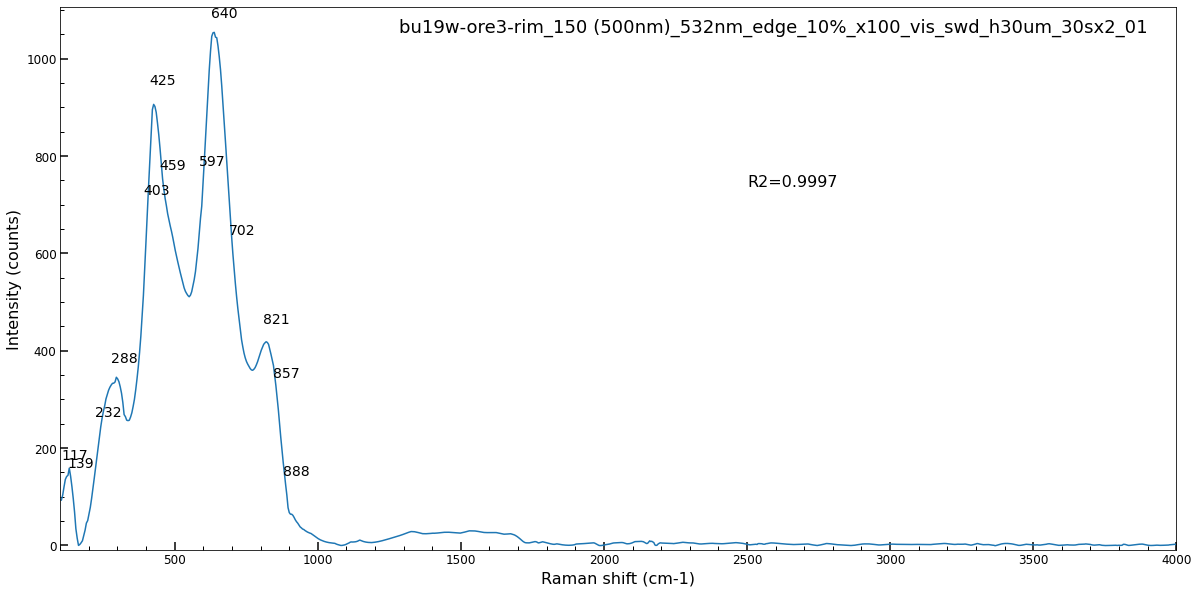

bu19w-ore4-core_150 (500nm)_532nm_edge_10%_x100_vis_swd_h30um_30sx2_01.dat


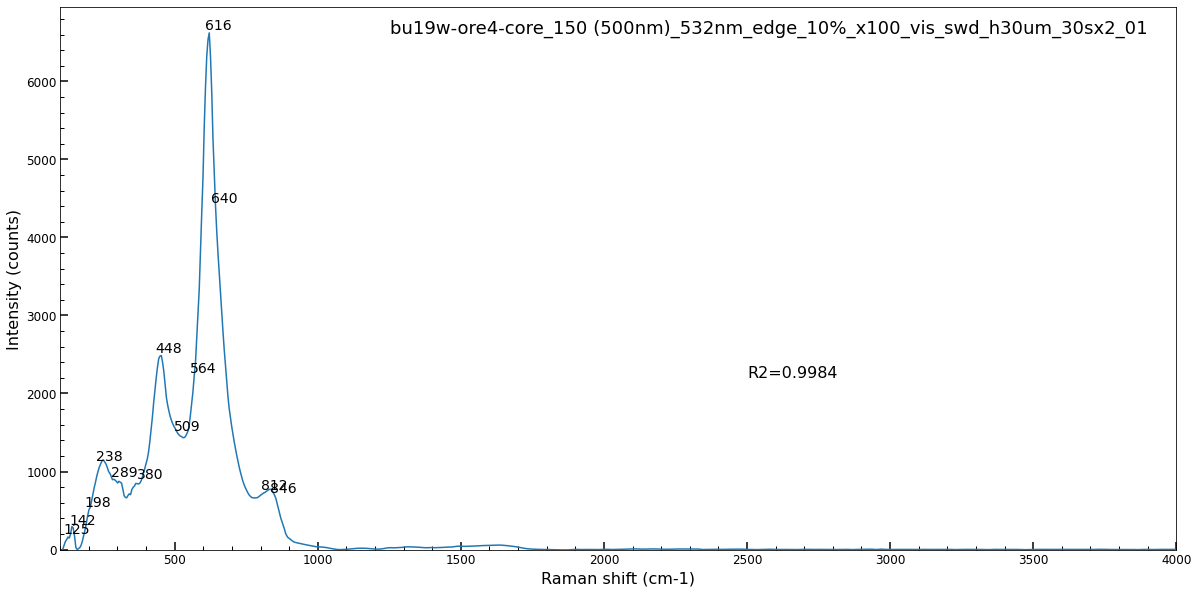

bu19w-ore4-rim_150 (500nm)_532nm_edge_10%_x100_vis_swd_h30um_30sx2_01.dat


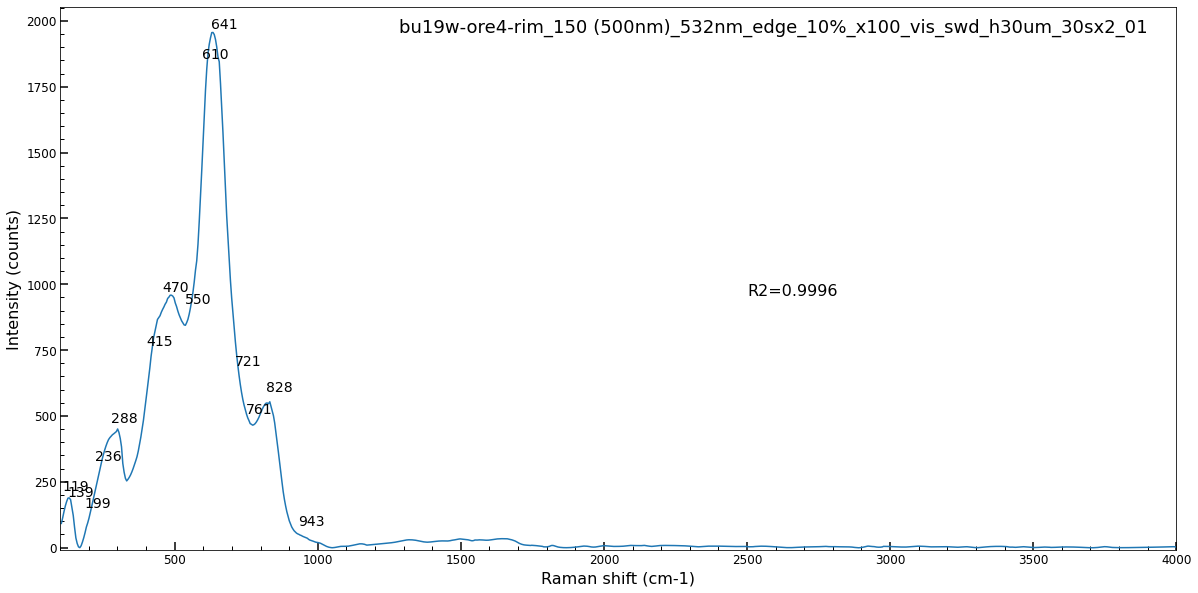

bu19w-ore4-top_150 (500nm)_532nm_edge_10%_x100_vis_swd_h30um_30sx2_01.dat


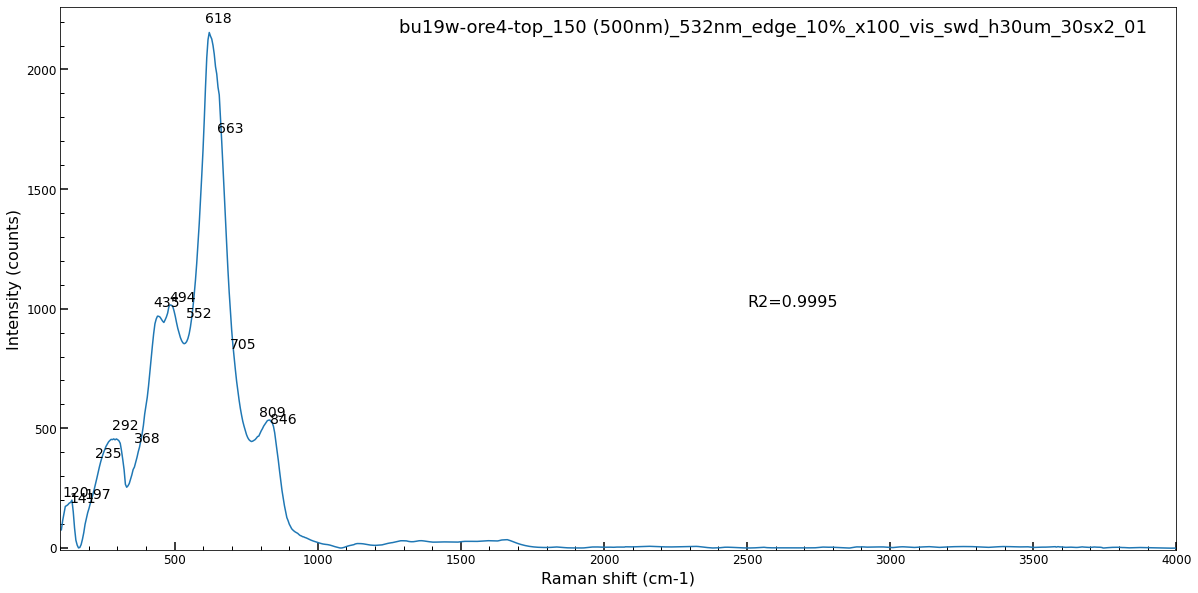

bu19w-ore5-core_150 (500nm)_532nm_edge_10%_x100_vis_swd_h30um_30sx2_01.dat


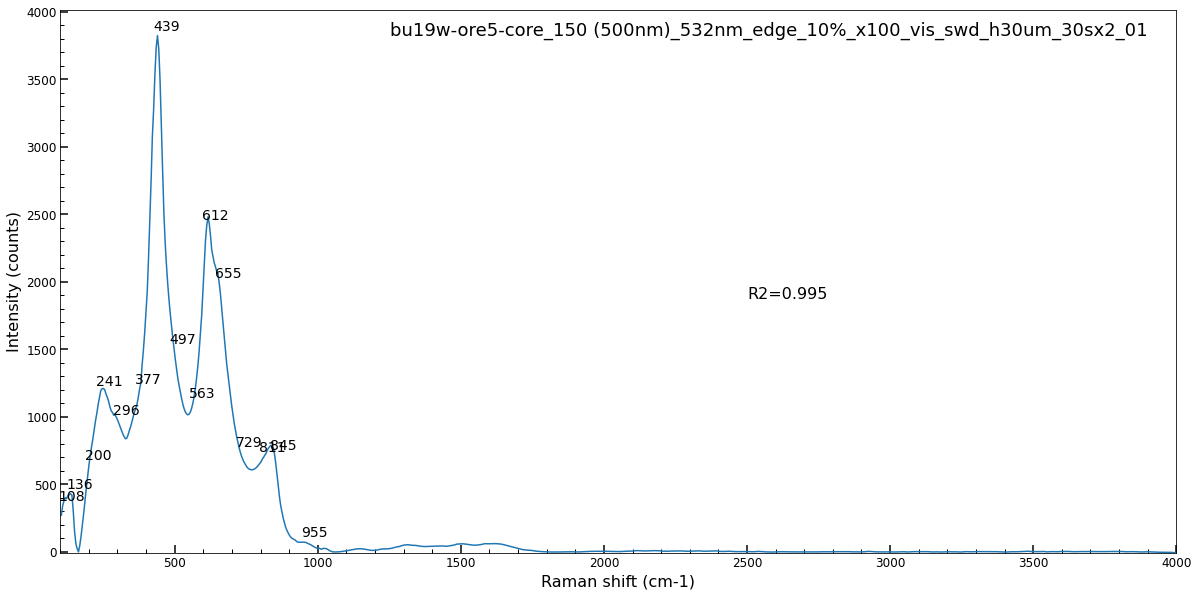

bu19w-ore5-rim_150 (500nm)_532nm_edge_10%_x100_vis_swd_h30um_30sx2_01.dat


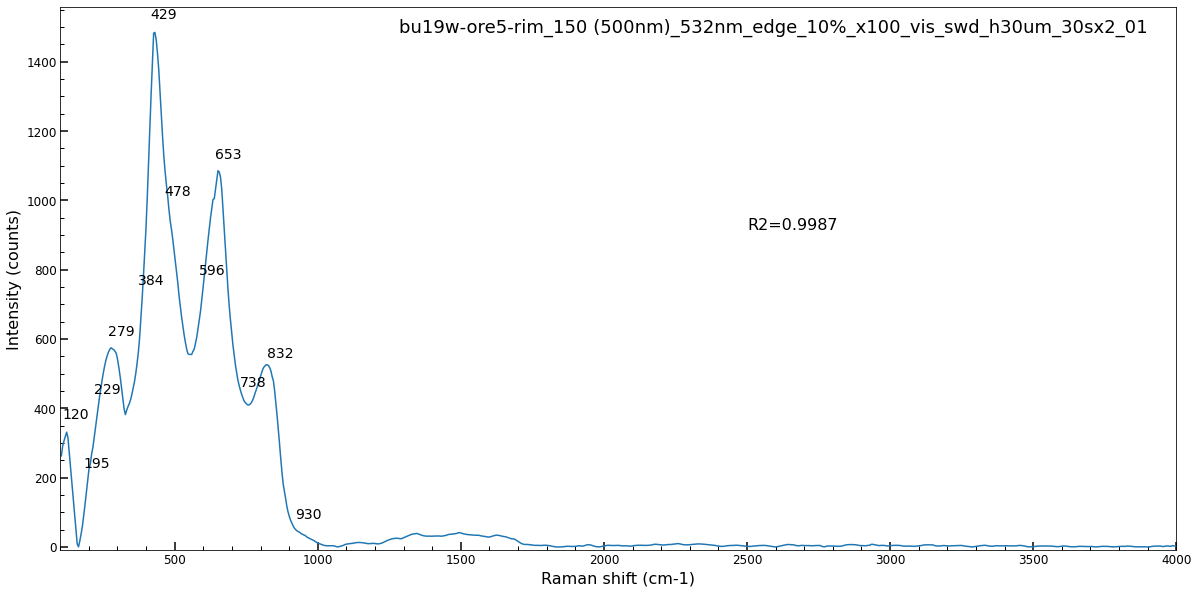

In [23]:
# --- multiple plotting of full range spectra 

for ii in range(len(spectra_files)):
    print(spectra_files[ii])
    spectrum_data(spectra_files[ii])

    df_spectrum_peaks = spectrum_data(spectra_files[ii])
    
        # --- make plot

    fig, ax = plt.subplots(figsize=(20,10))

    plt.plot(df_spectrum_peaks["wv"],df_spectrum_peaks["intensity"])

    for ii in range(df_spectrum_peaks.shape[0]):
        if df_spectrum_peaks.iloc[ii]["center"]!=0:
            text = str(int(df_spectrum_peaks.iloc[ii]["center"]))
            plt.text(df_spectrum_peaks.iloc[ii]["wv"]-15,df_spectrum_peaks.iloc[ii]["intensity"]+40,text,fontsize=14)

    plt.xlabel("Raman shift (cm-1)",fontsize=16)
    plt.xlim([100,4000])
    plt.ylabel("Intensity (counts)",fontsize=16)
    plt.ylim([-10,None])

    ax.xaxis.set_minor_locator(MultipleLocator(100))
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    ax.tick_params(axis='both', which='major',labelsize=12,direction='in',width=1.5,length=8)
    ax.tick_params(axis='both', which='minor',direction='in',width=1,length=4)

    plt.text(3900, np.quantile(df_spectrum_peaks["intensity"], 1),
             df_spectrum_peaks.iloc[0]["file"],horizontalalignment='right',fontsize=18)

    plt.text(2500, np.percentile(df_spectrum_peaks["intensity"], 97), 
             "R2="+str(round(float(df_spectrum_peaks.iloc[0]["R2"]),4)),fontsize=16)

    
    #plt.savefig('C:/Users/u0125722/Documents/Python_Scripts/output/figures/'+df_spectrum_peaks.iloc[0]["file"]+"_full_spectra.pdf")
    plt.show()

argentopyrite-r090026_1800 (450-850nm)_532nm_edge_10%_x100_vis_lwd_h100um_30sx2_01.dat


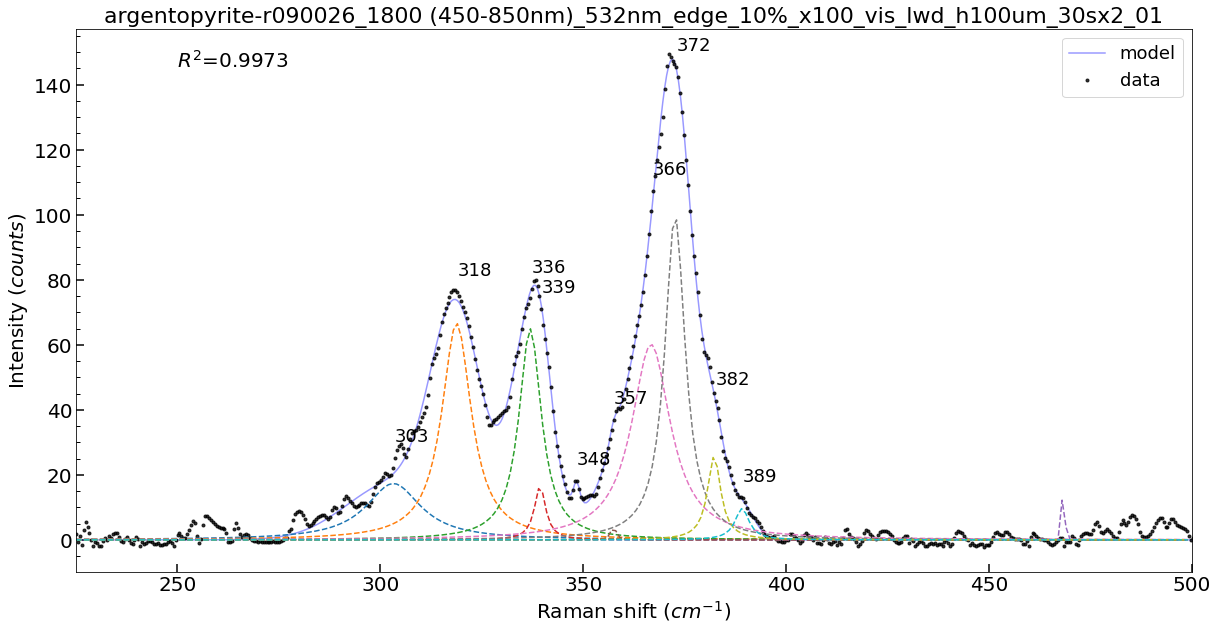

arsenopyrite-r050071_1800 (450-850nm)_532nm_edge_10%_x100_vis_lwd_h100um_30sx2_01.dat


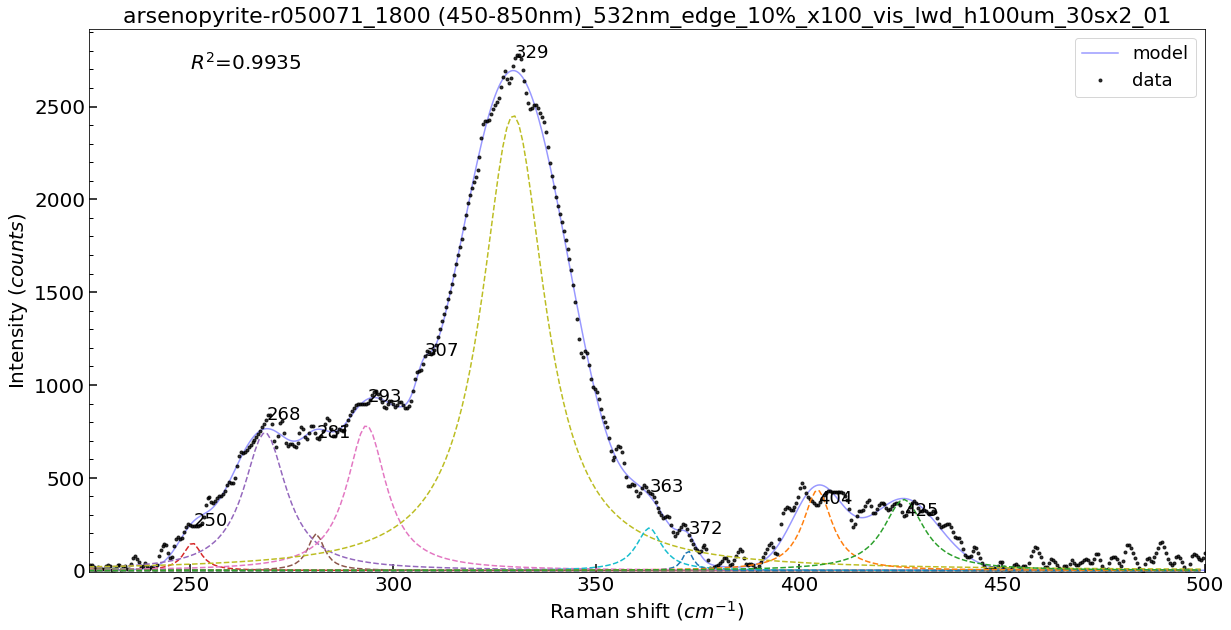

chalcopyrite-r050559_1800 (450-850nm)_532nm_edge_10%_x100_vis_lwd_h100um_30sx2_01.dat


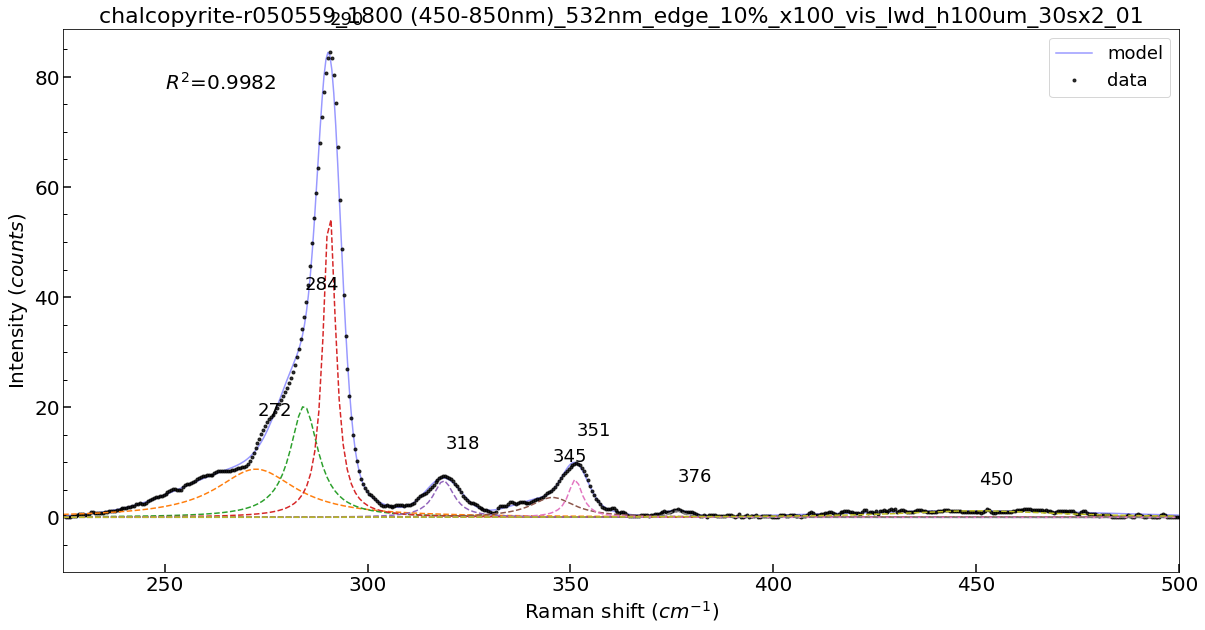

sul-nc-02-a-1_1800 (450-850nm)_532nm_edge_10%_x100_vis_lwd_h100um_30sx2_0.dat


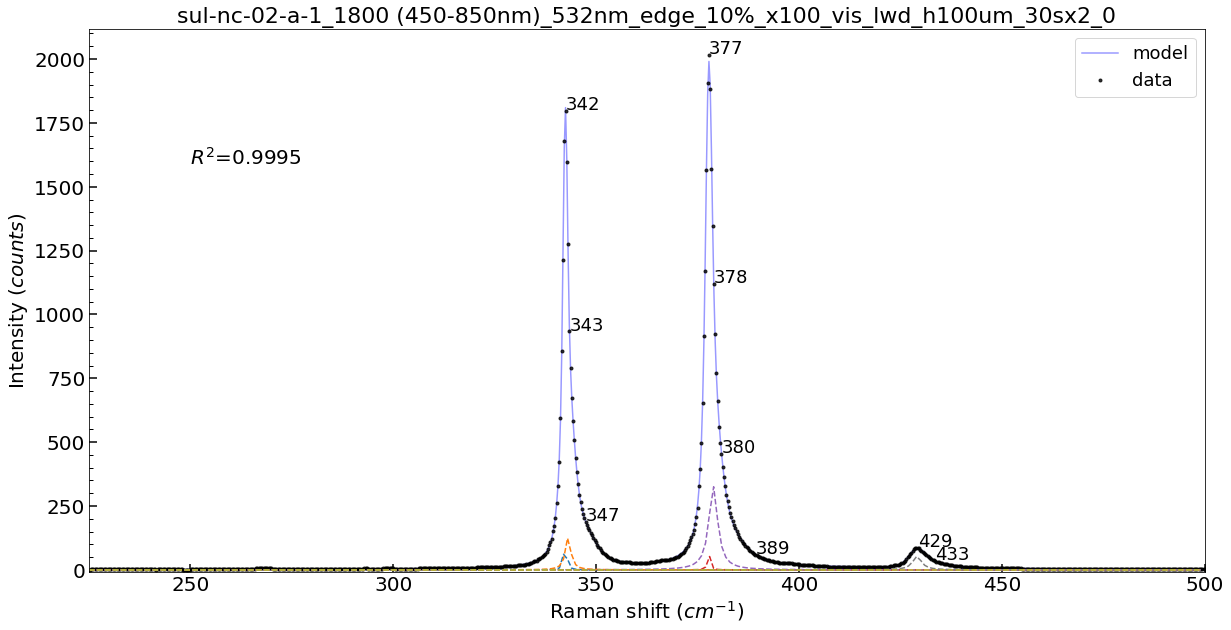

sul-nc-02-a-2_1800 (450-850nm)_532nm_edge_10%_x100_vis_lwd_h100um_30sx2_0.dat


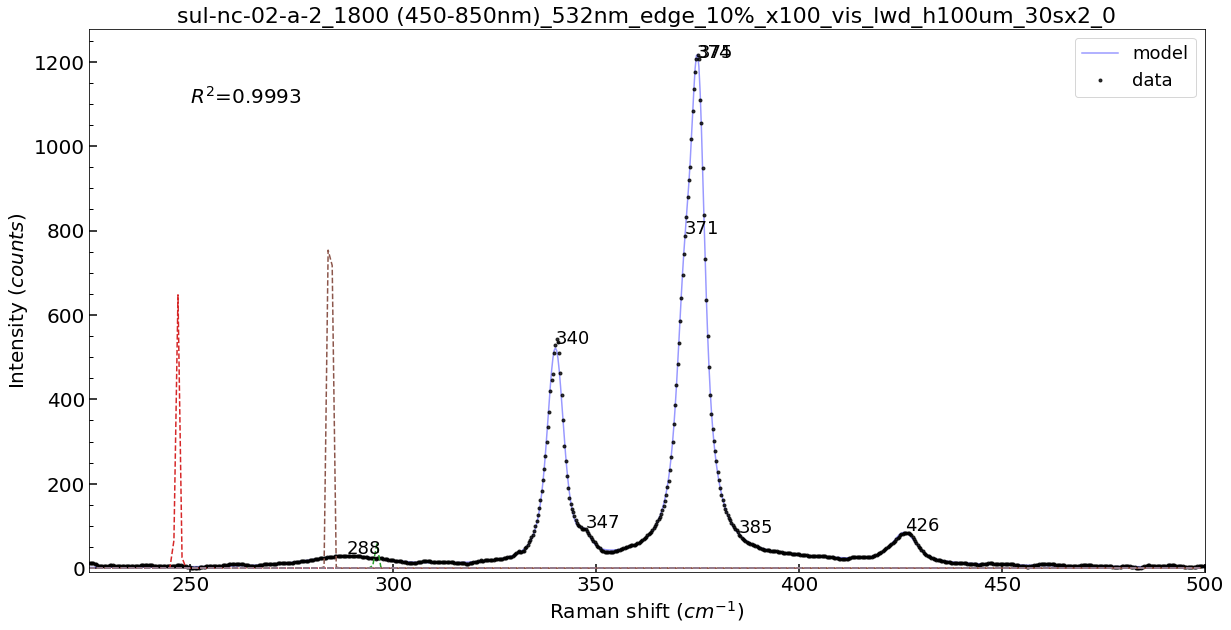

sul-nc-02-a-4_150 (500nm)_532nm_edge_10%_x100_vis_lwd_h100um_15sx2_0.dat


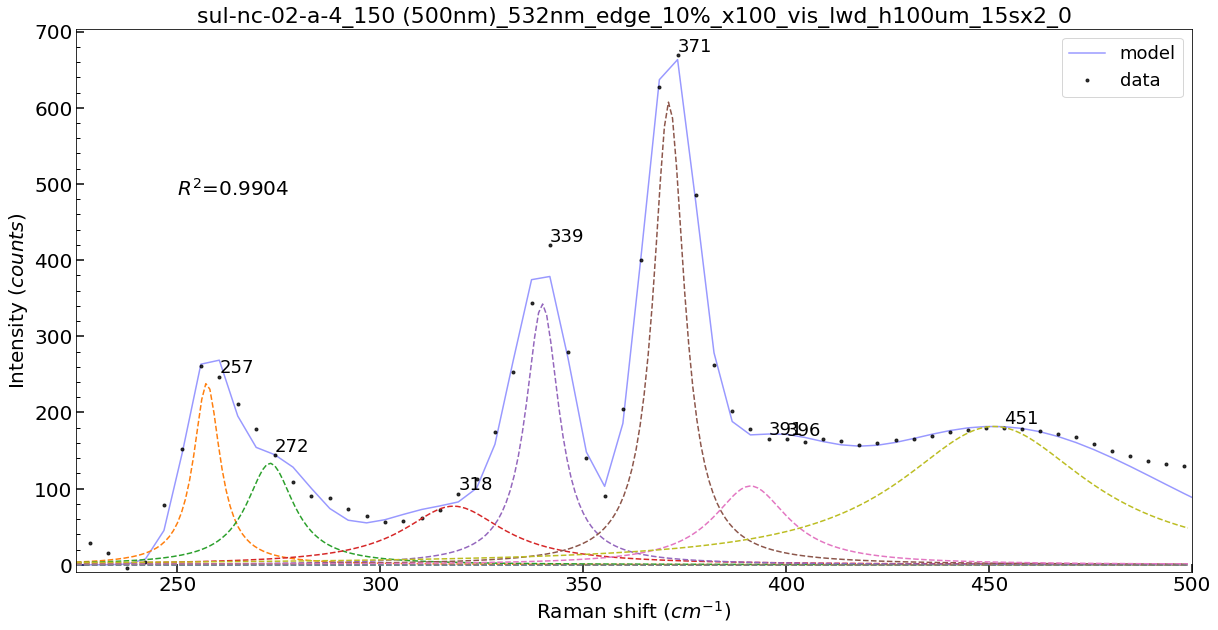

sul-nc-02-b-1_1800 (450-850nm)_532nm_edge_10%_x100_vis_lwd_h100um_30sx2_0.dat


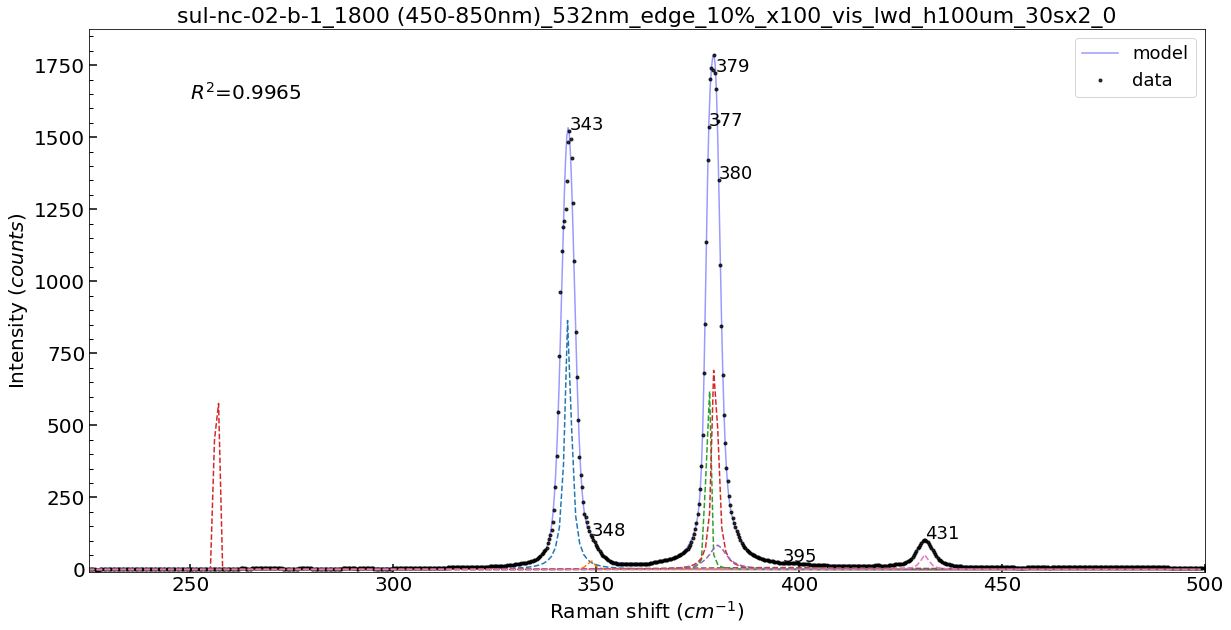

In [14]:
# --- multiple plotting of short range spectra with fitted peak

for ii in range(len(spectra_files)):
    print(spectra_files[ii])
    spectrum_data(spectra_files[ii])

    df_spectrum_peaks = spectrum_data(spectra_files[ii])
    
    # --- make plot

    fig, ax = plt.subplots(figsize=(20,10))

    plt.plot(df_spectrum_peaks["wv"],df_spectrum_peaks["model"],'b-', label='model', alpha=0.4)
    plt.plot(df_spectrum_peaks["wv"],df_spectrum_peaks["intensity"],'k.', label='data', alpha=0.8)
    plt.legend(loc='best',fontsize=18)
    
    for ii in range(df_spectrum_peaks.shape[0]):
        if 225 < df_spectrum_peaks.iloc[ii]["center"] < 500:
            text = str(int(df_spectrum_peaks.iloc[ii]["center"]))
            plt.text(df_spectrum_peaks.iloc[ii]["wv"],df_spectrum_peaks.iloc[ii]["intensity"]+5,text,fontsize=18)

   
    # --- get positions of peak data inside the overall file
    counter = 0
    peak_lines_loc = []

    for value in df_spectrum_peaks['center']:
        if value != 0:
            peak_lines_loc.append(counter)
        counter += 1

    num_peaks = len(peak_lines_loc)



    # --- add fitted peaks
    #mod = PseudoVoigtModel()
    x = np.arange(225,500)

    for peak in peak_lines_loc:
        a_0 = df_spectrum_peaks['a0'][peak]
        a_1 = df_spectrum_peaks['a1'][peak]
        a_2 = df_spectrum_peaks['a2'][peak]
        a_3 = df_spectrum_peaks['a3'][peak]
        y = gauss_lor_formula(x, a_0, a_1, a_2, a_3)
        plt.plot(x,y,ls='--')

        
    # --- adjust plot parameters
    
    plt.xlabel("Raman shift ($cm^{-1}$)",fontsize=20)
    plt.xlim([225,500])
    plt.ylabel("Intensity ($counts$)",fontsize=20)
    plt.ylim([-10,None])

    ax.xaxis.set_minor_locator(MultipleLocator(100))
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    ax.tick_params(axis='both', which='major',labelsize=20,direction='in',width=1.5,length=8)
    ax.tick_params(axis='both', which='minor',direction='in',width=1,length=4)

    plt.title(df_spectrum_peaks.iloc[0]["file"],horizontalalignment='center',fontsize=22)

    plt.text(250, np.percentile(df_spectrum_peaks["intensity"], 99.8), 
             "$R^2$="+str(round(float(df_spectrum_peaks.iloc[0]["R2"]),4)),fontsize=20)

        
    plt.savefig('C:/Users/u0125722/Documents/Python_Scripts/output/sultan/'+df_spectrum_peaks.iloc[0]["file"]+'.pdf')
    plt.show()

In [8]:
    # --- select one file to work with

#ff = -5
ff = spectra_files.index('sul-nc-02-a-2_1800 (450-850nm)_532nm_edge_10%_x100_vis_lwd_h100um_30sx2_0.dat')

print(peak_files[ff])
print(spectra_files[ff])

df_spectrum_peaks = spectrum_data(spectra_files[ff])

df_spectrum_peaks

sul-nc-02-a-2_1800 (450-850nm)_532nm_edge_10%_x100_vis_lwd_h100um_30sx2_0.peaks
sul-nc-02-a-2_1800 (450-850nm)_532nm_edge_10%_x100_vis_lwd_h100um_30sx2_0.dat


,file,sample,grating,laser,filter,objective,pinhole,acquisition,wv,intensity,...,area,FWHM,G/L,a0,a1,a2,a3,R2,WSSR,DoF
0,sul-nc-02-a-2_1800 (450-850nm)_532nm_edge_10%_...,sul-nc-02-a-2,1800 (450-850nm),532nm,10%,x100,h100um,30sx2,201.776,4.242610,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999337,130.712,631
1,sul-nc-02-a-2_1800 (450-850nm)_532nm_edge_10%_...,sul-nc-02-a-2,1800 (450-850nm),532nm,10%,x100,h100um,30sx2,202.094,1.665630,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999337,130.712,631
2,sul-nc-02-a-2_1800 (450-850nm)_532nm_edge_10%_...,sul-nc-02-a-2,1800 (450-850nm),532nm,10%,x100,h100um,30sx2,202.411,0.066109,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999337,130.712,631
3,sul-nc-02-a-2_1800 (450-850nm)_532nm_edge_10%_...,sul-nc-02-a-2,1800 (450-850nm),532nm,10%,x100,h100um,30sx2,202.729,-0.200119,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999337,130.712,631
4,sul-nc-02-a-2_1800 (450-850nm)_532nm_edge_10%_...,sul-nc-02-a-2,1800 (450-850nm),532nm,10%,x100,h100um,30sx2,203.045,-0.300972,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999337,130.712,631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2660,sul-nc-02-a-2_1800 (450-850nm)_532nm_edge_10%_...,sul-nc-02-a-2,1800 (450-850nm),532nm,10%,x100,h100um,30sx2,998.604,6.455320,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999337,130.712,631
2661,sul-nc-02-a-2_1800 (450-850nm)_532nm_edge_10%_...,sul-nc-02-a-2,1800 (450-850nm),532nm,10%,x100,h100um,30sx2,998.886,6.874480,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999337,130.712,631
2662,sul-nc-02-a-2_1800 (450-850nm)_532nm_edge_10%_...,sul-nc-02-a-2,1800 (450-850nm),532nm,10%,x100,h100um,30sx2,999.170,7.364140,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999337,130.712,631
2663,sul-nc-02-a-2_1800 (450-850nm)_532nm_edge_10%_...,sul-nc-02-a-2,1800 (450-850nm),532nm,10%,x100,h100um,30sx2,999.452,7.885040,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999337,130.712,631


288.4 
 24.3761 
 288.4 
 7.88034 
 1.0 

340.0 
 503.575 
 340.0 
 1.66443 
 1.0 

347.385 
 35.506 
 347.385 
 1.17398 
 1.0 

371.855 
 399.303 
 371.855 
 1.50602 
 1.0 

374.518 
 190.564 
 374.518 
 3.61715 
 1.0 

375.13 
 887.651 
 375.13 
 1.3186 
 1.0 

385.077 
 21.9594 
 385.077 
 29.4532 
 1.0 

426.0 
 70.0089 
 426.0 
 2.48899 
 1.0 



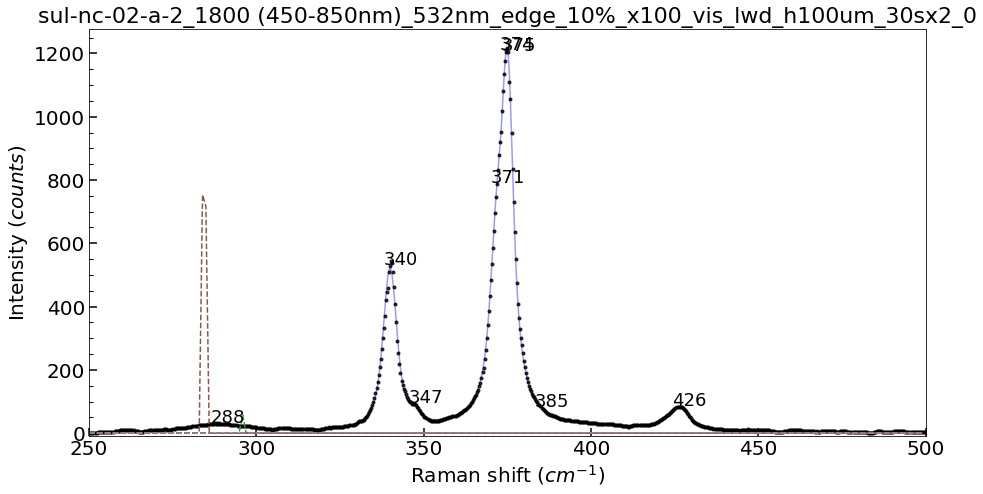

In [13]:
# --- make plot of single files

fig, ax = plt.subplots(figsize=(15,7.5))

plt.plot(df_spectrum_peaks["wv"],df_spectrum_peaks["model"],'b-', label='model', alpha=0.4)
plt.plot(df_spectrum_peaks["wv"],df_spectrum_peaks["intensity"],'k.', label='data', alpha=0.8)
# plt.legend(loc='best',fontsize=18)
    
for ii in range(df_spectrum_peaks.shape[0]):
    if 250 < df_spectrum_peaks.iloc[ii]["center"] < 500:
        text = str(int(df_spectrum_peaks.iloc[ii]["center"]))
        plt.text(df_spectrum_peaks.iloc[ii]["wv"]-2,df_spectrum_peaks.iloc[ii]["intensity"]+5,text,fontsize=18)
#         if np.percentile(df_spectrum_peaks.iloc[ii]["height"], 50) > df_spectrum_peaks.iloc[ii]["center"]:
#             text = str(int(df_spectrum_peaks.iloc[ii]["FWHM"]))
#             plt.text(df_spectrum_peaks.iloc[ii]["wv"]-15,df_spectrum_peaks.iloc[ii]["intensity"]+10,text,fontsize=18)
   
    # --- get positions of peak data inside the overall file
counter = 0
peak_lines_loc = []

for value in df_spectrum_peaks['center']:
    if value > 0:
        peak_lines_loc.append(counter)
    counter += 1

    # --- add fitted peaks
    
x = np.arange(250,500)

for peak in peak_lines_loc:
    print(df_spectrum_peaks['center'][peak],'\n',
         df_spectrum_peaks['a0'][peak],'\n',
         df_spectrum_peaks['a1'][peak],'\n',
         df_spectrum_peaks['a2'][peak],'\n',
         df_spectrum_peaks['a3'][peak],'\n')
    
    a_0 = df_spectrum_peaks['a0'][peak]
    a_1 = df_spectrum_peaks['a1'][peak]
    a_2 = df_spectrum_peaks['a2'][peak]
    a_3 = df_spectrum_peaks['a3'][peak]
    y = gauss_lor_formula(x, a_0, a_1, a_2, a_3)
    plt.plot(x,y,ls='--')

        
    # --- adjust plot parameters
    
plt.xlabel("Raman shift ($cm^{-1}$)",fontsize=20)
plt.xlim([250,500])
plt.ylabel("Intensity ($counts$)",fontsize=20)
plt.ylim([-10,None])

ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(axis='both', which='major',labelsize=20,direction='in',width=1.5,length=8)
ax.tick_params(axis='both', which='minor',direction='in',width=1,length=4)

plt.title(df_spectrum_peaks.iloc[0]["file"],horizontalalignment='center',fontsize=22)

# plt.text(300, np.percentile(df_spectrum_peaks["intensity"], 99.99), 
#             "$R^2$="+str(round(float(df_spectrum_peaks.iloc[0]["R2"]),4)),fontsize=20)

        
#plt.savefig('C:/Users/u0125722/Documents/Python_Scripts/output/figures/'+df_spectrum_peaks.iloc[0]["file"]+'_c.pdf')
plt.show()

In [ ]:
# --- TO CHECK!
    # 1. adjust the placement of peak labels

C:\Users\u0125722\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)


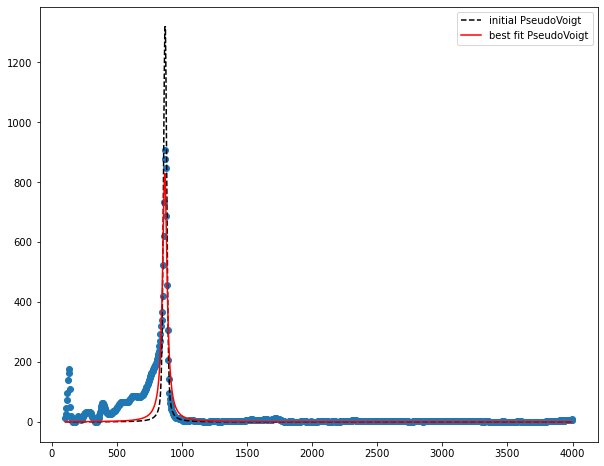

In [55]:
    # - fitting single peaks using predefined models from lmfit
    # --- https://lmfit.github.io/lmfit-py/examples/example_use_pandas.html#sphx-glr-examples-example-use-pandas-py
    
model = PseudoVoigtModel()


x = df_spectrum_peaks['wv'].astype(float)
y = df_spectrum_peaks["intensity"].astype(float)
params = model.guess(y, x=x)
#params = mod.make_params(cen=5, amp=200, wid=1)

result = model.fit(y, params, x=x)


fig, ax = plt.subplots(figsize=(10,8))

plt.plot(x, y, 'o')
plt.plot(x, result.init_fit, 'k--', label='initial PseudoVoigt')
plt.plot(x, result.best_fit, 'r-', label='best fit PseudoVoigt')
plt.legend(loc='best')
plt.show()

# result.plot_fit()
# plt.show()

#print(result.fit_report())   

[[Model]]
    ((Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_')) + Model(exponential, prefix='exp_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2821
    # data points      = 1068
    # variables        = 8
    chi-square         = 5217180.66
    reduced chi-square = 4921.86855
    Akaike info crit   = 9087.51157
    Bayesian info crit = 9127.29991
##  Warning: uncertainties could not be estimated:
    g1_amplitude:   at boundary
    g1_center:      at boundary
    g2_amplitude:   at boundary
    g2_sigma:       at boundary
[[Variables]]
    exp_amplitude:  99.1259268 (init = 24.81852)
    exp_decay:      1171.36629 (init = 1075.629)
    g1_amplitude:   10.0000000 (init = 2000)
    g1_center:      75.0000445 (init = 105)
    g1_sigma:       38.4368840 (init = 15)
    g1_fwhm:        90.5119433 == '2.3548200*g1_sigma'
    g1_height:      0.10379153 == '0.3989423*g1_amplitude/max(2.220446049250313e-16, g1_sigma)'
    g2_amplitude:   10.0000

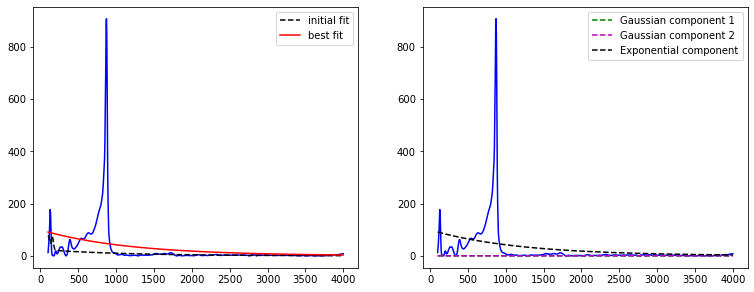

In [59]:
# - fitting multiple peaks using predefined models from lmfit
    # --- https://lmfit.github.io/lmfit-py/examples/documentation/builtinmodels_nistgauss.html#sphx-glr-examples-documentation-builtinmodels-nistgauss-py

x = df_spectrum_peaks['wv'].astype(float)
y = df_spectrum_peaks["intensity"].astype(float)

exp_mod = ExponentialModel(prefix='exp_')
pars = exp_mod.guess(y, x=x)

gauss1 = GaussianModel(prefix='g1_')
pars.update(gauss1.make_params())

pars['g1_center'].set(value=105, min=75, max=125)
pars['g1_sigma'].set(value=15, min=3)
pars['g1_amplitude'].set(value=2000, min=10)

gauss2 = GaussianModel(prefix='g2_')
pars.update(gauss2.make_params())

pars['g2_center'].set(value=155, min=125, max=175)
pars['g2_sigma'].set(value=15, min=3)
pars['g2_amplitude'].set(value=2000, min=10)

mod = gauss1 + gauss2 + exp_mod

init = mod.eval(pars, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.5))

fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
axes[0].plot(x, y, 'b')
axes[0].plot(x, init, 'k--', label='initial fit')
axes[0].plot(x, out.best_fit, 'r-', label='best fit')
axes[0].legend(loc='best')

comps = out.eval_components(x=x)
axes[1].plot(x, y, 'b')
axes[1].plot(x, comps['g1_'], 'g--', label='Gaussian component 1')
axes[1].plot(x, comps['g2_'], 'm--', label='Gaussian component 2')
axes[1].plot(x, comps['exp_'], 'k--', label='Exponential component')
axes[1].legend(loc='best')

plt.show()

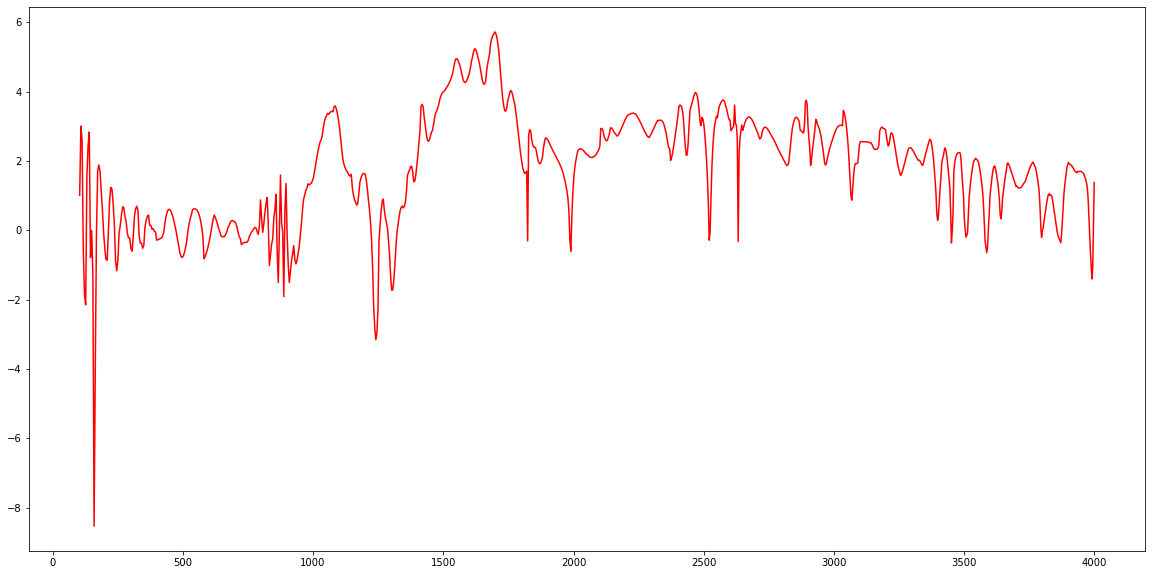

In [18]:
df = pd.read_csv(base_dir+"processed_spectra/"+spectra_files[0], sep=' ', header=None, names=['wv','intensity','stddev','model','residuals','wtresiduals'])

#df

fig, ax = plt.subplots(figsize=(20,10))

#plt.plot(df["wv"],df["intensity"],'k.', label='data')
#plt.plot(df["wv"],df["model"],'b-', label='model')

plt.plot(df["wv"],df["wtresiduals"],'r-', label='weighted residuals')